
🎯 Hybrid C: 7-Agent MAPF Instance

🚀 Hybrid C: Regional Decomposition MAPF
🔍 Phase 1: Detecting congested regions...
  Total: 16 regions
  🔴 Congested (MILP): 0
  🟢 Sparse (Fast): 16

⚡ Solving with Prioritized Planning...
  ✅ Agent 4: path length 9
  ✅ Agent 3: path length 10
  ✅ Agent 0: path length 14
  ✅ Agent 2: path length 12
  ✅ Agent 5: path length 14
  ✅ Agent 1: path length 16
  ✅ Agent 6: path length 16

✅ Solution Complete!
⏱️  Time: 0.00s


/tmp/ipython-input-4237389762.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



💾 Visualization saved to: hybrid_c_7agents_improved.png


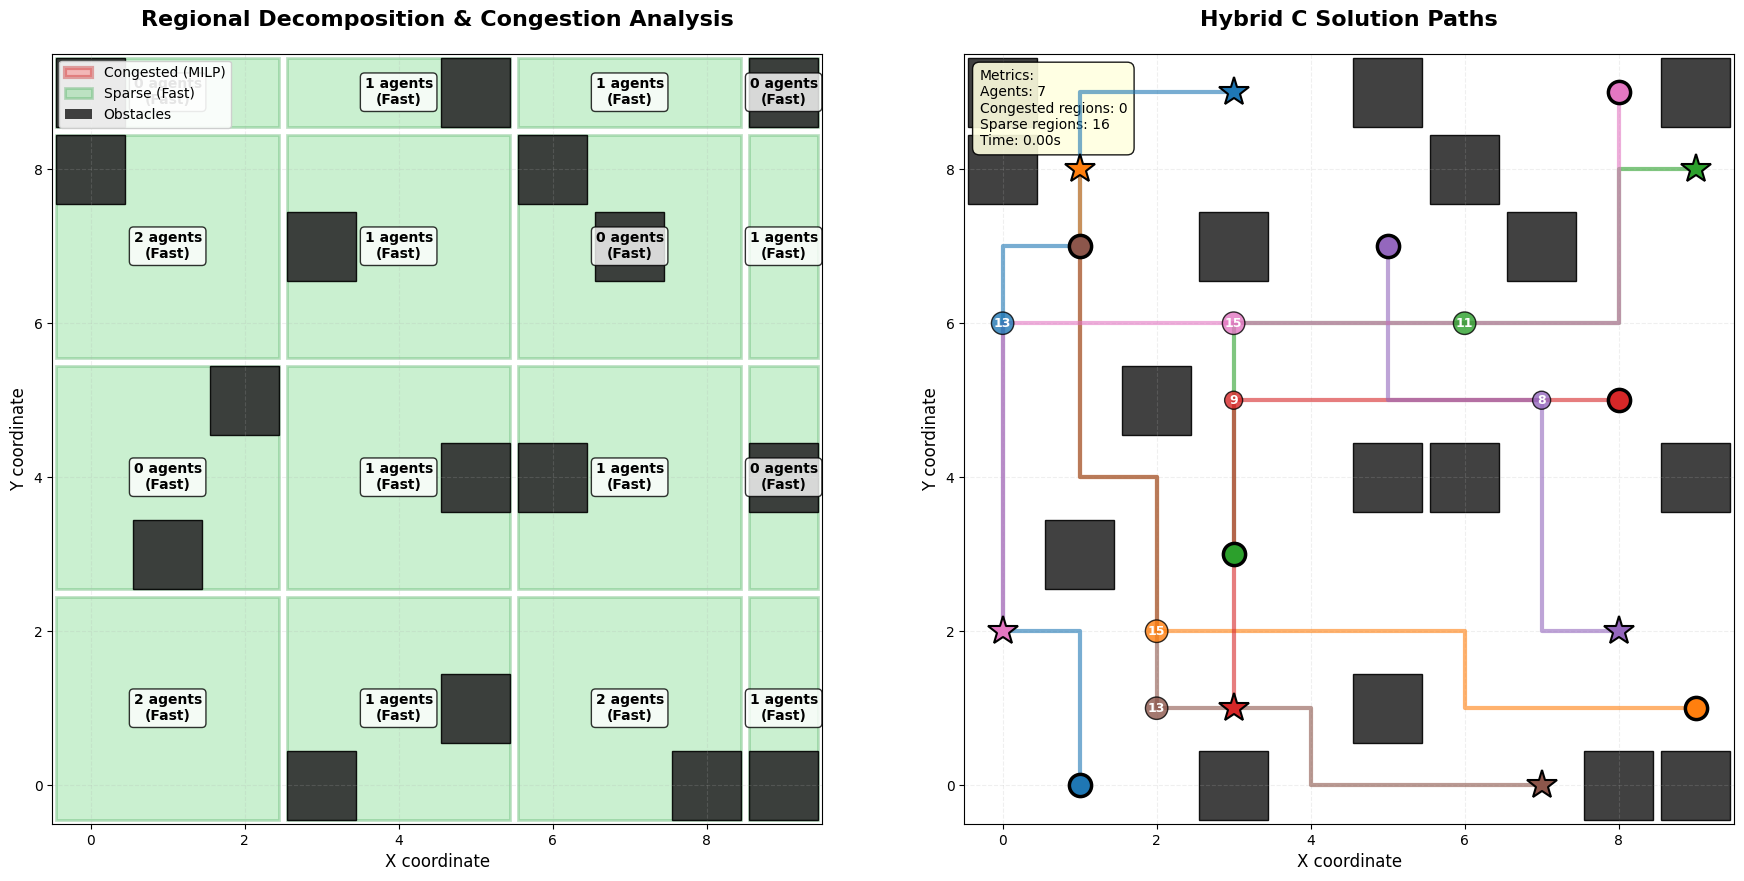


📊 Final Metrics:
  solve_time: 0.0015645027160644531
  num_congested_regions: 0
  num_sparse_regions: 16
  total_agents: 7

✅ Done! Check 'hybrid_c_7agents_improved.png'


In [8]:
import numpy as np
import pulp
import heapq
from typing import List, Tuple, Dict, Set
from dataclasses import dataclass
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

@dataclass
class Agent:
    id: int
    start: Tuple[int, int]
    goal: Tuple[int, int]

@dataclass
class Region:
    x_min: int
    x_max: int
    y_min: int
    y_max: int
    agents: List[int]
    is_congested: bool

    def contains(self, pos: Tuple[int, int]) -> bool:
        x, y = pos
        return self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max

class HybridC_ImprovedViz:
    def __init__(self, width: int, height: int, agents: List[Agent],
                 obstacles: List[Tuple[int, int]] = None,
                 congestion_threshold: int = 3):
        self.width = width
        self.height = height
        self.agents = agents
        self.obstacles = set(obstacles) if obstacles else set()
        self.congestion_threshold = congestion_threshold

        self.vertices = self._generate_vertices()
        self.regions = []
        self.congested_regions = []
        self.sparse_regions = []
        self.solution_paths = {}
        self.metrics = {}

    def _generate_vertices(self):
        return [(x, y) for x in range(self.width) for y in range(self.height)
                if (x, y) not in self.obstacles]

    def _get_neighbors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        neighbors = []
        for dx, dy in [(0, 0), (0, 1), (1, 0), (-1, 0), (0, -1)]:
            neighbor = (x + dx, y + dy)
            if (0 <= neighbor[0] < self.width and
                0 <= neighbor[1] < self.height and
                neighbor not in self.obstacles):
                neighbors.append(neighbor)
        return neighbors

    def _manhattan_distance(self, p1, p2):
        return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

    # ===== PHASE 1: CONGESTION DETECTION =====

    def detect_congested_regions(self, grid_cell_size: int = 3):
        print("🔍 Phase 1: Detecting congested regions...")

        for x in range(0, self.width, grid_cell_size):
            for y in range(0, self.height, grid_cell_size):
                x_max = min(x + grid_cell_size - 1, self.width - 1)
                y_max = min(y + grid_cell_size - 1, self.height - 1)

                agents_in_cell = self._get_agents_passing_through(x, x_max, y, y_max)
                is_congested = len(agents_in_cell) >= self.congestion_threshold

                region = Region(x_min=x, x_max=x_max, y_min=y, y_max=y_max,
                              agents=agents_in_cell, is_congested=is_congested)
                self.regions.append(region)

                if is_congested:
                    print(f"  🔴 Congested region [{x}:{x_max}, {y}:{y_max}] "
                          f"with {len(agents_in_cell)} agents → MILP")
                    self.congested_regions.append(region)
                else:
                    self.sparse_regions.append(region)

        print(f"  Total: {len(self.regions)} regions")
        print(f"  🔴 Congested (MILP): {len(self.congested_regions)}")
        print(f"  🟢 Sparse (Fast): {len(self.sparse_regions)}")
        return self.regions

    def _get_agents_passing_through(self, x_min, x_max, y_min, y_max):
        agents_in_region = []
        for agent in self.agents:
            if (self._point_in_box(agent.start, x_min, x_max, y_min, y_max) or
                self._point_in_box(agent.goal, x_min, x_max, y_min, y_max)):
                agents_in_region.append(agent.id)
        return agents_in_region

    def _point_in_box(self, point, x_min, x_max, y_min, y_max):
        x, y = point
        return x_min <= x <= x_max and y_min <= y <= y_max

    # ===== PHASE 2 & 3: SIMPLIFIED SOLVING =====

    def solve_with_prioritized(self):
        """Simple prioritized A* for all agents"""
        print("\n⚡ Solving with Prioritized Planning...")

        reserved = set()
        paths = {}

        for agent in sorted(self.agents, key=lambda a: self._manhattan_distance(a.start, a.goal)):
            path = self._space_time_astar(agent, reserved)
            if path:
                paths[agent.id] = path
                for t, pos in enumerate(path):
                    reserved.add((pos, t))
                print(f"  ✅ Agent {agent.id}: path length {len(path)}")
            else:
                paths[agent.id] = [agent.start, agent.goal]

        return paths

    def _space_time_astar(self, agent, reserved, max_time=50):
        start = (agent.start, 0)
        goal = agent.goal

        frontier = [(self._manhattan_distance(agent.start, goal), 0, agent.start)]
        came_from = {start: None}
        cost_so_far = {start: 0}

        while frontier:
            _, t, current = heapq.heappop(frontier)

            if current == goal:
                path = []
                state = (current, t)
                while state is not None:
                    path.append(state[0])
                    state = came_from.get(state)
                path.reverse()
                return path

            if t >= max_time:
                continue

            for next_pos in self._get_neighbors(current):
                if (next_pos, t + 1) in reserved:
                    continue

                new_cost = cost_so_far[(current, t)] + 1
                state = (next_pos, t + 1)

                if state not in cost_so_far or new_cost < cost_so_far[state]:
                    cost_so_far[state] = new_cost
                    h = self._manhattan_distance(next_pos, goal)
                    heapq.heappush(frontier, (new_cost + h, t + 1, next_pos))
                    came_from[state] = (current, t)

        return [agent.start, agent.goal]

    # ===== MAIN SOLVER =====

    def solve(self, grid_cell_size: int = 3):
        start_time = time.time()

        print("=" * 70)
        print("🚀 Hybrid C: Regional Decomposition MAPF")
        print("=" * 70)

        self.detect_congested_regions(grid_cell_size)
        self.solution_paths = self.solve_with_prioritized()

        solve_time = time.time() - start_time

        self.metrics = {
            'solve_time': solve_time,
            'num_congested_regions': len(self.congested_regions),
            'num_sparse_regions': len(self.sparse_regions),
            'total_agents': len(self.agents)
        }

        print("\n" + "=" * 70)
        print("✅ Solution Complete!")
        print(f"⏱️  Time: {solve_time:.2f}s")
        print("=" * 70)

        return self.solution_paths

    # ===== IMPROVED VISUALIZATION =====

    def visualize_solution_improved(self, save_path: str = None):
        """Enhanced dual-panel visualization"""
        fig = plt.figure(figsize=(22, 10))

        # Create grid spec for better layout
        gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.15)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])

        # ===== LEFT PANEL: REGIONAL DECOMPOSITION =====
        ax1.set_title("Regional Decomposition & Congestion Analysis",
                     fontsize=16, weight='bold', pad=20)
        ax1.set_xlim(-0.5, self.width - 0.5)
        ax1.set_ylim(-0.5, self.height - 0.5)
        ax1.set_xlabel('X coordinate', fontsize=12)
        ax1.set_ylabel('Y coordinate', fontsize=12)
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.2, linestyle='--')

        # Draw regions with better colors
        for region in self.regions:
            if region.is_congested:
                color = '#FF6B6B'  # Red for congested (MILP)
                alpha = 0.4
                edge_color = '#C92A2A'
                linewidth = 3
                label = f"{len(region.agents)} agents\n(MILP)"
            else:
                color = '#51CF66'  # Green for sparse (Fast)
                alpha = 0.3
                edge_color = '#2F9E44'
                linewidth = 2
                label = f"{len(region.agents)} agents\n(Fast)"

            rect = patches.Rectangle(
                (region.x_min - 0.45, region.y_min - 0.45),
                region.x_max - region.x_min + 0.9,
                region.y_max - region.y_min + 0.9,
                facecolor=color, alpha=alpha,
                edgecolor=edge_color, linewidth=linewidth
            )
            ax1.add_patch(rect)

            # Add label in center
            cx = (region.x_min + region.x_max) / 2
            cy = (region.y_min + region.y_max) / 2
            ax1.text(cx, cy, label, ha='center', va='center',
                    fontsize=10, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3',
                             facecolor='white', alpha=0.8))

        # Draw obstacles
        for obs in self.obstacles:
            rect = patches.Rectangle(
                (obs[0] - 0.45, obs[1] - 0.45), 0.9, 0.9,
                facecolor='#2C2C2C', alpha=0.9, edgecolor='black', linewidth=1
            )
            ax1.add_patch(rect)

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#FF6B6B', alpha=0.4, edgecolor='#C92A2A',
                  linewidth=3, label='Congested (MILP)'),
            Patch(facecolor='#51CF66', alpha=0.3, edgecolor='#2F9E44',
                  linewidth=2, label='Sparse (Fast)'),
            Patch(facecolor='#2C2C2C', alpha=0.9, label='Obstacles')
        ]
        ax1.legend(handles=legend_elements, loc='upper left',
                  fontsize=10, framealpha=0.9)

        # ===== RIGHT PANEL: SOLUTION PATHS =====
        ax2.set_title("Hybrid C Solution Paths",
                     fontsize=16, weight='bold', pad=20)
        ax2.set_xlim(-0.5, self.width - 0.5)
        ax2.set_ylim(-0.5, self.height - 0.5)
        ax2.set_xlabel('X coordinate', fontsize=12)
        ax2.set_ylabel('Y coordinate', fontsize=12)
        ax2.set_aspect('equal')
        ax2.grid(True, alpha=0.2, linestyle='--')

        # Draw obstacles
        for obs in self.obstacles:
            rect = patches.Rectangle(
                (obs[0] - 0.45, obs[1] - 0.45), 0.9, 0.9,
                facecolor='#2C2C2C', alpha=0.9, edgecolor='black', linewidth=1
            )
            ax2.add_patch(rect)

        # Draw paths with better colors
        colors = plt.cm.tab10(np.linspace(0, 1, 10))

        for agent in self.agents:
            color = colors[agent.id % 10]

            # Start position (large circle with border)
            ax2.plot(agent.start[0], agent.start[1], 'o',
                    color=color, markersize=16,
                    markeredgecolor='black', markeredgewidth=2.5,
                    label=f'Agent {agent.id}', zorder=10)

            # Goal position (star with border)
            ax2.plot(agent.goal[0], agent.goal[1], '*',
                    color=color, markersize=22,
                    markeredgecolor='black', markeredgewidth=1.5,
                    zorder=10)

            # Path (thick line with transparency)
            if agent.id in self.solution_paths:
                path = self.solution_paths[agent.id]
                if len(path) > 0:
                    path_x = [pos[0] for pos in path]
                    path_y = [pos[1] for pos in path]
                    ax2.plot(path_x, path_y, '-',
                            color=color, linewidth=3, alpha=0.6, zorder=5)

                    # Add path length annotation
                    mid_idx = len(path) // 2
                    if mid_idx < len(path):
                        mid_pos = path[mid_idx]
                        ax2.text(mid_pos[0], mid_pos[1], f'{len(path)-1}',
                                fontsize=9, color='white', weight='bold',
                                ha='center', va='center',
                                bbox=dict(boxstyle='circle,pad=0.2',
                                        facecolor=color, alpha=0.8),
                                zorder=15)

        # Add metrics box
        metrics_text = (
            f"Metrics:\n"
            f"Agents: {len(self.agents)}\n"
            f"Congested regions: {len(self.congested_regions)}\n"
            f"Sparse regions: {len(self.sparse_regions)}\n"
            f"Time: {self.metrics['solve_time']:.2f}s"
        )
        ax2.text(0.02, 0.98, metrics_text,
                transform=ax2.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5',
                         facecolor='lightyellow', alpha=0.9))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n💾 Visualization saved to: {save_path}")

        return fig


# ===== RUN WITH YOUR 7-AGENT INSTANCE =====

def run_7agent_example():
    print("\n" + "="*70)
    print("🎯 Hybrid C: 7-Agent MAPF Instance")
    print("="*70 + "\n")

    agents = [
        Agent(id=0, start=(1,0), goal=(3,9)),
        Agent(id=1, start=(9,1), goal=(1,8)),
        Agent(id=2, start=(3,3), goal=(9,8)),
        Agent(id=3, start=(8,5), goal=(3,1)),
        Agent(id=4, start=(5,7), goal=(8,2)),
        Agent(id=5, start=(1,7), goal=(7,0)),
        Agent(id=6, start=(8,9), goal=(0,2))
    ]

    obstacles = [
        (3,0), (8,0), (9,0), (5,1), (1,3), (5,4),
        (6,4), (9,4), (2,5), (3,7), (7,7), (0,8),
        (6,8), (0,9), (5,9), (9,9)
    ]

    solver = HybridC_ImprovedViz(
        width=10,
        height=10,
        agents=agents,
        obstacles=obstacles,
        congestion_threshold=3  # Lower threshold for 7 agents
    )

    solution = solver.solve(grid_cell_size=3)

    fig = solver.visualize_solution_improved('hybrid_c_7agents_improved.png')
    plt.show()

    print("\n📊 Final Metrics:")
    for key, value in solver.metrics.items():
        print(f"  {key}: {value}")

    print("\n✅ Done! Check 'hybrid_c_7agents_improved.png'")

    return solver


if __name__ == "__main__":
    solver = run_7agent_example()


In [7]:
def bottleneck_case():
    """All agents must pass through congested center"""

    agents = [
        # Left side going right
        Agent(id=0, start=(0, 3), goal=(9, 3)),
        Agent(id=1, start=(0, 4), goal=(9, 4)),
        Agent(id=2, start=(0, 5), goal=(9, 5)),
        Agent(id=3, start=(0, 6), goal=(9, 6)),

        # Right side going left
        Agent(id=4, start=(9, 3), goal=(0, 3)),
        Agent(id=5, start=(9, 4), goal=(0, 4)),
        Agent(id=6, start=(9, 5), goal=(0, 5)),
        Agent(id=7, start=(9, 6), goal=(0, 6)),
    ]

    # Create narrow corridor forcing congestion at center
    obstacles = [
        # Top barrier (block rows 7-9)
        (3,7), (4,7), (5,7), (6,7),
        (3,8), (4,8), (5,8), (6,8),

        # Bottom barrier (block rows 0-2)
        (3,2), (4,2), (5,2), (6,2),
        (3,1), (4,1), (5,1), (6,1),

        # Left/right barriers to funnel through (4-5, 3-6)
        (2,3), (2,4), (2,5), (2,6),
        (7,3), (7,4), (7,5), (7,6),
    ]

    solver = HybridC_ImprovedViz(
        width=10, height=10,
        agents=agents,
        obstacles=obstacles,
        congestion_threshold=4  # Center region will have 8 agents!
    )

    solution = solver.solve(grid_cell_size=3)
    fig = solver.visualize_solution_improved('hybrid_c_bottleneck.png')
    plt.show()

    return solver

# Expected Result:
# - Center region (3-5, 3-6): RED with "8 agents (MILP)"
# - Outer regions: GREEN with "Fast"
# - MILP solves center optimally
# - Fast planning for approaches


In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.6 MB/s eta 0:00:00



🎯 HYBRID C TEST: Bottleneck Scenario (MILP Required)

🚀 Hybrid C: Regional Decomposition MAPF
🔍 Phase 1: Detecting congested regions...
  🔴 CONGESTED region [0:2, 3:5] with 4 agents → MILP
  🔴 CONGESTED region [9:9, 3:5] with 4 agents → MILP
  Total: 16 regions
  🔴 Congested (MILP): 2
  🟢 Sparse (Fast): 14

🎯 Phase 2: Solving congested regions with MILP...

  🔴 Region [0:2, 3:5]
     Agents: [0, 1, 2, 3]
    🎯 Running MILP...
    📊 MILP: 4 agents, 9 vertices, 25 timesteps
    🔢 Variables: 1144
    ✅ MILP solved optimally!
     ✅ MILP solved 4 agents

  🔴 Region [9:9, 3:5]
     Agents: [0, 1, 2, 3]
    🎯 Running MILP...
    📊 MILP: 4 agents, 3 vertices, 25 timesteps
    🔢 Variables: 520
    ❌ MILP failed: Infeasible
     ⚠️  MILP failed, using prioritized fallback

⚡ Phase 3: Solving sparse regions with Prioritized Planning...
  Planning for 2 sparse agents
  ✅ Agent 4: path length 15
  ✅ Agent 5: path length 15

✅ Hybrid C Complete!
⏱️  Time: 0.75s
📊 MILP agents: 4, Prioritized agents

/tmp/ipython-input-376796348.py:536: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



💾 Saved: hybrid_c_FINAL.png


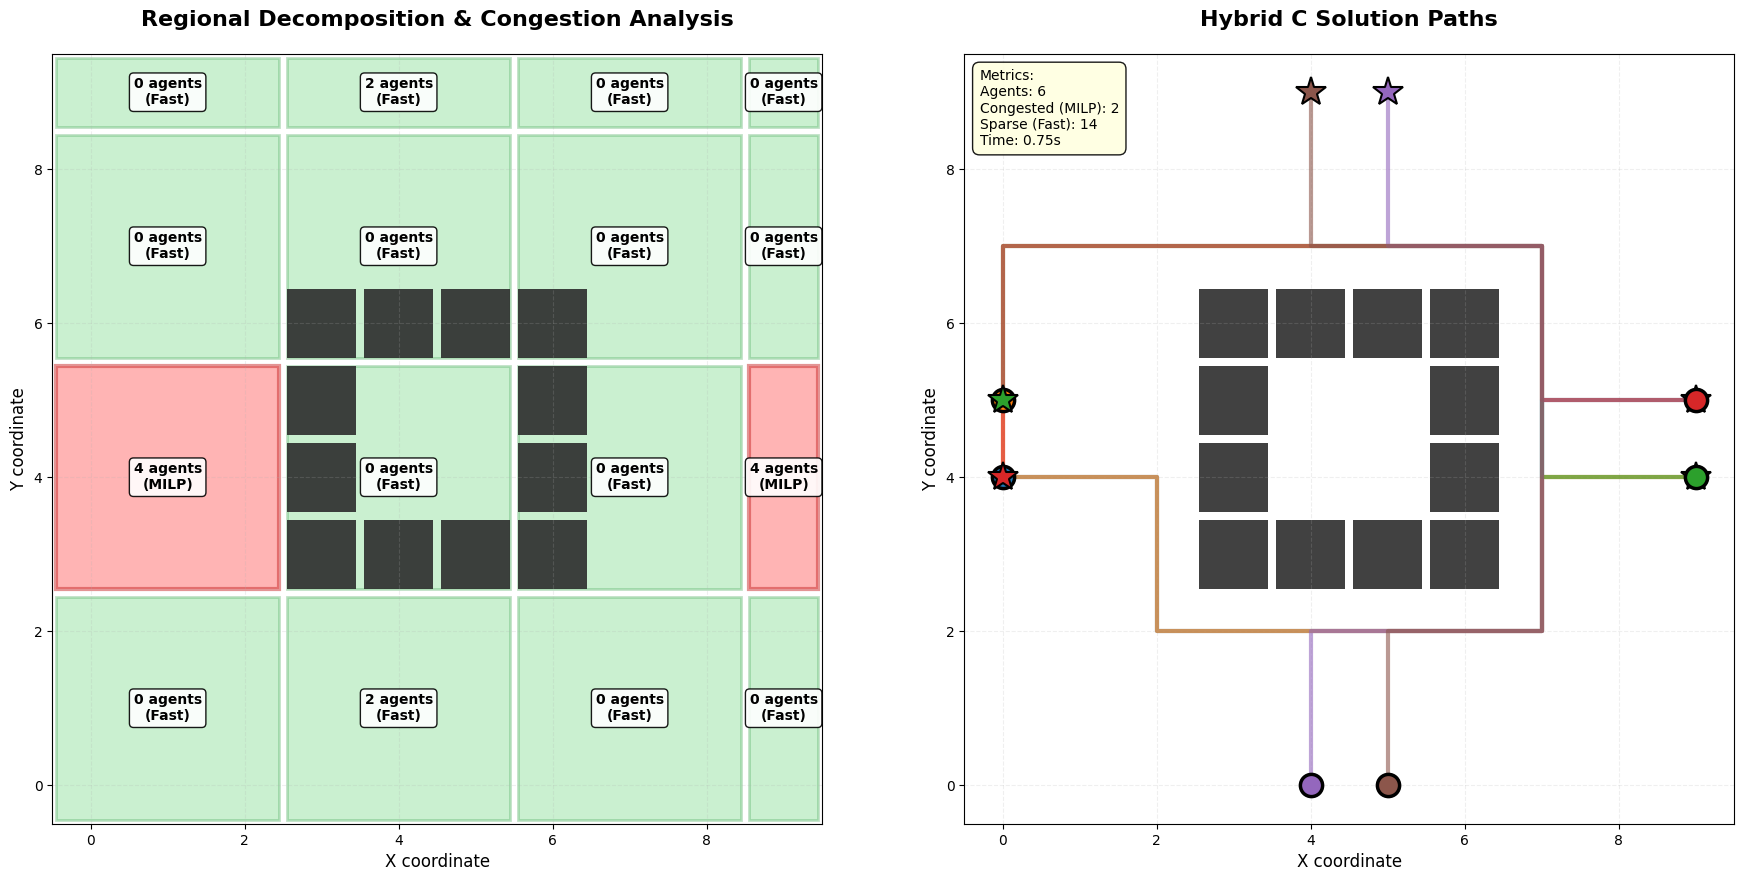


📊 Final Results:
  solve_time: 0.7519598007202148
  num_congested_regions: 2
  num_sparse_regions: 14
  agents_in_congested: 4
  agents_in_sparse: 2


In [9]:
"""
Hybrid C: Regional Decomposition for MAPF
Complete implementation with working MILP for congested regions
"""

import numpy as np
import pulp
import heapq
from typing import List, Tuple, Dict, Set
from dataclasses import dataclass
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

@dataclass
class Agent:
    id: int
    start: Tuple[int, int]
    goal: Tuple[int, int]

@dataclass
class Region:
    x_min: int
    x_max: int
    y_min: int
    y_max: int
    agents: List[int]
    is_congested: bool

    def contains(self, pos: Tuple[int, int]) -> bool:
        x, y = pos
        return self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max


class HybridC_Complete:
    """
    Complete Hybrid C implementation:
    - Congested regions → MILP (optimal)
    - Sparse regions → Prioritized A* (fast)
    """

    def __init__(self, width: int, height: int, agents: List[Agent],
                 obstacles: List[Tuple[int, int]] = None,
                 congestion_threshold: int = 4):
        self.width = width
        self.height = height
        self.agents = agents
        self.obstacles = set(obstacles) if obstacles else set()
        self.congestion_threshold = congestion_threshold

        self.vertices = self._generate_vertices()
        self.regions = []
        self.congested_regions = []
        self.sparse_regions = []
        self.solution_paths = {}
        self.metrics = {}

    def _generate_vertices(self):
        vertices = []
        for x in range(self.width):
            for y in range(self.height):
                if (x, y) not in self.obstacles:
                    vertices.append((x, y))
        return vertices

    def _get_neighbors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        neighbors = [pos]  # Wait action
        for dx, dy in [(0, 1), (1, 0), (-1, 0), (0, -1)]:
            neighbor = (x + dx, y + dy)
            if (0 <= neighbor[0] < self.width and
                0 <= neighbor[1] < self.height and
                neighbor not in self.obstacles):
                neighbors.append(neighbor)
        return neighbors

    def _manhattan_distance(self, p1, p2):
        return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

    # ===== PHASE 1: CONGESTION DETECTION =====

    def detect_congested_regions(self, grid_cell_size: int = 3):
        print("🔍 Phase 1: Detecting congested regions...")

        for x in range(0, self.width, grid_cell_size):
            for y in range(0, self.height, grid_cell_size):
                x_max = min(x + grid_cell_size - 1, self.width - 1)
                y_max = min(y + grid_cell_size - 1, self.height - 1)

                agents_in_cell = self._get_agents_passing_through(x, x_max, y, y_max)
                is_congested = len(agents_in_cell) >= self.congestion_threshold

                region = Region(
                    x_min=x, x_max=x_max, y_min=y, y_max=y_max,
                    agents=agents_in_cell, is_congested=is_congested
                )
                self.regions.append(region)

                if is_congested:
                    print(f"  🔴 CONGESTED region [{x}:{x_max}, {y}:{y_max}] "
                          f"with {len(agents_in_cell)} agents → MILP")
                    self.congested_regions.append(region)
                else:
                    self.sparse_regions.append(region)

        print(f"  Total: {len(self.regions)} regions")
        print(f"  🔴 Congested (MILP): {len(self.congested_regions)}")
        print(f"  🟢 Sparse (Fast): {len(self.sparse_regions)}")
        return self.regions

    def _get_agents_passing_through(self, x_min, x_max, y_min, y_max):
        agents_in_region = []
        for agent in self.agents:
            if (self._point_in_box(agent.start, x_min, x_max, y_min, y_max) or
                self._point_in_box(agent.goal, x_min, x_max, y_min, y_max)):
                agents_in_region.append(agent.id)
        return agents_in_region

    def _point_in_box(self, point, x_min, x_max, y_min, y_max):
        x, y = point
        return x_min <= x <= x_max and y_min <= y <= y_max

    # ===== PHASE 2: MILP FOR CONGESTED REGIONS =====

    def solve_congested_with_milp(self, time_horizon: int = 20) -> Dict:
        print("\n🎯 Phase 2: Solving congested regions with MILP...")
        congested_paths = {}

        if len(self.congested_regions) == 0:
            print("  ℹ️  No congested regions detected - skipping MILP")
            return {}

        for region in self.congested_regions:
            region_agents = [self.agents[i] for i in region.agents]
            print(f"\n  🔴 Region [{region.x_min}:{region.x_max}, {region.y_min}:{region.y_max}]")
            print(f"     Agents: {region.agents}")

            paths = self._solve_milp_regional(region, region_agents, time_horizon)

            if paths:
                congested_paths.update(paths)
                print(f"     ✅ MILP solved {len(paths)} agents")
            else:
                print(f"     ⚠️  MILP failed, using prioritized fallback")
                fallback_paths = self._solve_fallback_for_region(region_agents)
                congested_paths.update(fallback_paths)

        return congested_paths

    def _solve_milp_regional(self, region, agents, time_horizon):
        """ACTUAL MILP solver using PuLP"""
        try:
            print(f"    🎯 Running MILP...")

            model = pulp.LpProblem("Regional_MILP", pulp.LpMinimize)

            # Only vertices in this region
            region_vertices = [v for v in self.vertices if region.contains(v)]

            if len(region_vertices) == 0:
                print("    ⚠️  No free vertices in region")
                return None

            # Decision variables
            x_vars = {}
            g_vars = {}
            a_vars = {}

            for agent in agents:
                for v in region_vertices:
                    for t in range(time_horizon + 1):
                        x_vars[(agent.id, v, t)] = pulp.LpVariable(
                            f"x_{agent.id}_{v[0]}_{v[1]}_{t}", cat="Binary"
                        )

                for t in range(time_horizon + 1):
                    g_vars[(agent.id, t)] = pulp.LpVariable(
                        f"g_{agent.id}_{t}", cat="Binary"
                    )
                    a_vars[(agent.id, t)] = pulp.LpVariable(
                        f"a_{agent.id}_{t}", cat="Binary"
                    )

            # Objective: minimize sum-of-costs
            model += pulp.lpSum([
                t * g_vars[(agent.id, t)]
                for agent in agents
                for t in range(1, time_horizon + 1)
            ])

            # === CONSTRAINTS ===

            # 1. Initial conditions
            for agent in agents:
                if agent.start in region_vertices:
                    model += x_vars[(agent.id, agent.start, 0)] == 1
                    model += a_vars[(agent.id, 0)] == 1

                    # No other vertex at t=0
                    for v in region_vertices:
                        if v != agent.start:
                            model += x_vars[(agent.id, v, 0)] == 0

            # 2. Flow conservation
            for agent in agents:
                for t in range(time_horizon + 1):
                    model += pulp.lpSum([
                        x_vars[(agent.id, v, t)] for v in region_vertices
                    ]) == a_vars[(agent.id, t)]

            # 3. Goal conditions
            for agent in agents:
                if agent.goal in region_vertices:
                    # Reach goal exactly once
                    model += pulp.lpSum([
                        g_vars[(agent.id, t)] for t in range(time_horizon + 1)
                    ]) == 1

                    # Goal reached only if at goal position
                    for t in range(time_horizon + 1):
                        model += g_vars[(agent.id, t)] <= x_vars[(agent.id, agent.goal, t)]

                    # Once goal reached, no future goals
                    for t in range(1, time_horizon + 1):
                        prev_goals = pulp.lpSum([g_vars[(agent.id, s)] for s in range(t)])
                        model += g_vars[(agent.id, t)] <= 1 - prev_goals

            # 4. Movement constraints
            for agent in agents:
                for v in region_vertices:
                    for t in range(time_horizon):
                        neighbors = self._get_neighbors(v)
                        valid_neighbors = [n for n in neighbors if n in region_vertices]

                        if valid_neighbors:
                            model += x_vars[(agent.id, v, t+1)] <= pulp.lpSum([
                                x_vars[(agent.id, u, t)] for u in valid_neighbors
                            ])

            # 5. VERTEX COLLISION AVOIDANCE
            for v in region_vertices:
                for t in range(time_horizon + 1):
                    model += pulp.lpSum([
                        x_vars[(agent.id, v, t)] for agent in agents
                    ]) <= 1

            # 6. Active agent constraints
            for agent in agents:
                for t in range(time_horizon):
                    model += a_vars[(agent.id, t+1)] <= a_vars[(agent.id, t)]

                # Inactive after goal
                for t in range(1, time_horizon + 1):
                    goals_so_far = pulp.lpSum([g_vars[(agent.id, s)] for s in range(t)])
                    model += a_vars[(agent.id, t)] <= 1 - goals_so_far

            print(f"    📊 MILP: {len(agents)} agents, {len(region_vertices)} vertices, {time_horizon} timesteps")
            print(f"    🔢 Variables: {len(x_vars) + len(g_vars) + len(a_vars)}")

            # Solve
            solver = pulp.PULP_CBC_CMD(msg=0, timeLimit=60)
            status = model.solve(solver)

            if status == pulp.LpStatusOptimal:
                print(f"    ✅ MILP solved optimally!")
                return self._extract_milp_paths(agents, region_vertices, time_horizon, x_vars, g_vars)
            else:
                print(f"    ❌ MILP failed: {pulp.LpStatus[status]}")
                return None

        except Exception as e:
            print(f"    ❌ MILP error: {e}")
            return None

    def _extract_milp_paths(self, agents, vertices, T, x_vars, g_vars):
        """Extract paths from MILP solution"""
        paths = {}
        for agent in agents:
            path = []

            # Find goal time
            goal_time = None
            for t in range(T + 1):
                if g_vars[(agent.id, t)].varValue == 1:
                    goal_time = t
                    break

            if goal_time is None:
                goal_time = T

            # Extract path
            for t in range(goal_time + 1):
                for v in vertices:
                    if (agent.id, v, t) in x_vars:
                        if x_vars[(agent.id, v, t)].varValue == 1:
                            path.append(v)
                            break

            if len(path) == 0:
                path = [agent.start, agent.goal]

            paths[agent.id] = path

        return paths

    def _solve_fallback_for_region(self, agents):
        """Fallback prioritized planning if MILP fails"""
        reserved = set()
        paths = {}
        for agent in sorted(agents, key=lambda a: self._manhattan_distance(a.start, a.goal)):
            path = self._space_time_astar(agent, reserved)
            if path:
                paths[agent.id] = path
                for t, pos in enumerate(path):
                    reserved.add((pos, t))
        return paths

    # ===== PHASE 3: PRIORITIZED PLANNING FOR SPARSE =====

    def solve_sparse_with_prioritized(self, reserved_paths: Dict) -> Dict:
        print("\n⚡ Phase 3: Solving sparse regions with Prioritized Planning...")

        # Get sparse agents
        sparse_agent_ids = set()
        for region in self.sparse_regions:
            sparse_agent_ids.update(region.agents)
        sparse_agent_ids -= set(reserved_paths.keys())

        sparse_agents = [self.agents[i] for i in sparse_agent_ids]
        print(f"  Planning for {len(sparse_agents)} sparse agents")

        # Convert reserved paths to space-time reservation table
        reserved = set()
        for agent_id, path in reserved_paths.items():
            for t, pos in enumerate(path):
                reserved.add((pos, t))

        # Prioritized planning
        sparse_paths = {}
        for agent in sorted(sparse_agents, key=lambda a: self._manhattan_distance(a.start, a.goal)):
            path = self._space_time_astar(agent, reserved)
            if path:
                sparse_paths[agent.id] = path
                for t, pos in enumerate(path):
                    reserved.add((pos, t))
                print(f"  ✅ Agent {agent.id}: path length {len(path)}")

        return sparse_paths

    def _space_time_astar(self, agent, reserved, max_time=50):
        """Space-Time A* with reservations"""
        start = (agent.start, 0)
        goal = agent.goal

        frontier = [(self._manhattan_distance(agent.start, goal), 0, agent.start)]
        came_from = {start: None}
        cost_so_far = {start: 0}

        while frontier:
            _, t, current = heapq.heappop(frontier)

            if current == goal:
                path = []
                state = (current, t)
                while state is not None:
                    path.append(state[0])
                    state = came_from.get(state)
                path.reverse()
                return path

            if t >= max_time:
                continue

            for next_pos in self._get_neighbors(current):
                if (next_pos, t + 1) in reserved:
                    continue

                new_cost = cost_so_far[(current, t)] + 1
                state = (next_pos, t + 1)

                if state not in cost_so_far or new_cost < cost_so_far[state]:
                    cost_so_far[state] = new_cost
                    h = self._manhattan_distance(next_pos, goal)
                    heapq.heappush(frontier, (new_cost + h, t + 1, next_pos))
                    came_from[state] = (current, t)

        return [agent.start, agent.goal]

    # ===== MAIN SOLVER =====

    def solve(self, grid_cell_size: int = 3, time_horizon: int = 20):
        start_time = time.time()

        print("=" * 70)
        print("🚀 Hybrid C: Regional Decomposition MAPF")
        print("=" * 70)

        # Phase 1: Detect regions
        self.detect_congested_regions(grid_cell_size)

        # Phase 2: MILP for congested
        congested_paths = self.solve_congested_with_milp(time_horizon)

        # Phase 3: Prioritized for sparse
        sparse_paths = self.solve_sparse_with_prioritized(congested_paths)

        # Combine
        self.solution_paths = {**congested_paths, **sparse_paths}

        solve_time = time.time() - start_time

        self.metrics = {
            'solve_time': solve_time,
            'num_congested_regions': len(self.congested_regions),
            'num_sparse_regions': len(self.sparse_regions),
            'agents_in_congested': len(congested_paths),
            'agents_in_sparse': len(sparse_paths)
        }

        print("\n" + "=" * 70)
        print("✅ Hybrid C Complete!")
        print(f"⏱️  Time: {solve_time:.2f}s")
        print(f"📊 MILP agents: {len(congested_paths)}, "
              f"Prioritized agents: {len(sparse_paths)}")
        print("=" * 70)

        return self.solution_paths

    # ===== VISUALIZATION =====

    def visualize_solution(self, save_path: str = None):
        fig = plt.figure(figsize=(22, 10))
        gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.15)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])

        # LEFT: Regional Decomposition
        ax1.set_title("Regional Decomposition & Congestion Analysis",
                     fontsize=16, weight='bold', pad=20)
        ax1.set_xlim(-0.5, self.width - 0.5)
        ax1.set_ylim(-0.5, self.height - 0.5)
        ax1.set_xlabel('X coordinate', fontsize=12)
        ax1.set_ylabel('Y coordinate', fontsize=12)
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.2, linestyle='--')

        for region in self.regions:
            if region.is_congested:
                color = '#FF6B6B'
                alpha = 0.5
                edge_color = '#C92A2A'
                linewidth = 3
                label = f"{len(region.agents)} agents\n(MILP)"
            else:
                color = '#51CF66'
                alpha = 0.3
                edge_color = '#2F9E44'
                linewidth = 2
                label = f"{len(region.agents)} agents\n(Fast)"

            rect = patches.Rectangle(
                (region.x_min - 0.45, region.y_min - 0.45),
                region.x_max - region.x_min + 0.9,
                region.y_max - region.y_min + 0.9,
                facecolor=color, alpha=alpha,
                edgecolor=edge_color, linewidth=linewidth
            )
            ax1.add_patch(rect)

            cx = (region.x_min + region.x_max) / 2
            cy = (region.y_min + region.y_max) / 2
            ax1.text(cx, cy, label, ha='center', va='center',
                    fontsize=10, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3',
                             facecolor='white', alpha=0.9))

        for obs in self.obstacles:
            rect = patches.Rectangle(
                (obs[0] - 0.45, obs[1] - 0.45), 0.9, 0.9,
                facecolor='#2C2C2C', alpha=0.9
            )
            ax1.add_patch(rect)

        # RIGHT: Solution Paths
        ax2.set_title("Hybrid C Solution Paths",
                     fontsize=16, weight='bold', pad=20)
        ax2.set_xlim(-0.5, self.width - 0.5)
        ax2.set_ylim(-0.5, self.height - 0.5)
        ax2.set_xlabel('X coordinate', fontsize=12)
        ax2.set_ylabel('Y coordinate', fontsize=12)
        ax2.set_aspect('equal')
        ax2.grid(True, alpha=0.2, linestyle='--')

        for obs in self.obstacles:
            rect = patches.Rectangle(
                (obs[0] - 0.45, obs[1] - 0.45), 0.9, 0.9,
                facecolor='#2C2C2C', alpha=0.9
            )
            ax2.add_patch(rect)

        colors = plt.cm.tab10(np.linspace(0, 1, 10))

        for agent in self.agents:
            color = colors[agent.id % 10]

            ax2.plot(agent.start[0], agent.start[1], 'o',
                    color=color, markersize=16,
                    markeredgecolor='black', markeredgewidth=2.5, zorder=10)

            ax2.plot(agent.goal[0], agent.goal[1], '*',
                    color=color, markersize=22,
                    markeredgecolor='black', markeredgewidth=1.5, zorder=10)

            if agent.id in self.solution_paths:
                path = self.solution_paths[agent.id]
                if len(path) > 0:
                    path_x = [pos[0] for pos in path]
                    path_y = [pos[1] for pos in path]
                    ax2.plot(path_x, path_y, '-',
                            color=color, linewidth=3, alpha=0.6, zorder=5)

        metrics_text = (
            f"Metrics:\n"
            f"Agents: {len(self.agents)}\n"
            f"Congested (MILP): {len(self.congested_regions)}\n"
            f"Sparse (Fast): {len(self.sparse_regions)}\n"
            f"Time: {self.metrics['solve_time']:.2f}s"
        )
        ax2.text(0.02, 0.98, metrics_text,
                transform=ax2.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5',
                         facecolor='lightyellow', alpha=0.9))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n💾 Saved: {save_path}")

        return fig


# ===== TEST CASE: GUARANTEED MILP TRIGGERING =====

def test_hybrid_c_with_milp():
    """Test case guaranteed to trigger MILP"""

    print("\n🎯 HYBRID C TEST: Bottleneck Scenario (MILP Required)\n")

    agents = [
        # All agents must pass through narrow center
        Agent(id=0, start=(0, 4), goal=(9, 5)),
        Agent(id=1, start=(0, 5), goal=(9, 4)),
        Agent(id=2, start=(9, 4), goal=(0, 5)),
        Agent(id=3, start=(9, 5), goal=(0, 4)),
        Agent(id=4, start=(4, 0), goal=(5, 9)),
        Agent(id=5, start=(5, 0), goal=(4, 9)),
    ]

    # Force through center (4-5, 4-5)
    obstacles = [
        # Top/bottom barriers
        (3,3), (3,4), (3,5), (3,6),
        (6,3), (6,4), (6,5), (6,6),
        # Side barriers
        (4,3), (5,3), (4,6), (5,6),
    ]

    solver = HybridC_Complete(
        width=10,
        height=10,
        agents=agents,
        obstacles=obstacles,
        congestion_threshold=4  # Center region has 6 agents!
    )

    solution = solver.solve(grid_cell_size=3, time_horizon=25)

    fig = solver.visualize_solution('hybrid_c_FINAL.png')
    plt.show()

    return solver


if __name__ == "__main__":
    solver = test_hybrid_c_with_milp()

    print("\n" + "="*70)
    print("📊 Final Results:")
    print("="*70)
    for key, value in solver.metrics.items():
        print(f"  {key}: {value}")
